In [1]:
import os, glob, re, spacy, nltk
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy.attrs

%matplotlib inline

from sklearn.utils import shuffle
from spacy import displacy
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from collections import Counter
from scipy import stats
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Corpus preparation

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [32]:
#root_path = 'MyDrive/datascience/data/' 

# Corpus of *US_Presidents*

In [3]:
US_Presidents= [file for file in os.listdir("MyDrive/MyDrive/datascience/data/US_Presidents") if re.match(re.compile(".*.txt"), file)]

In [4]:
Categories=["US_Presidents","Women_Scientists"]
articles_Presidents = []
for i in US_Presidents:
    groups = re.match(re.compile("(.*).txt"), i).groups()
    name, title,category = i, groups[0], Categories[0]
    articles_Presidents.append([name, title, category])

In [5]:
data_Presidents = []

for x in articles_Presidents:
    with open("MyDrive/MyDrive/datascience/data/US_Presidents/"+ x[0], "r", encoding="utf-8") as file:
        content = file.read()
        splited_data = content.splitlines()
        content = ''.join(splited_data)
        data_Presidents.append([ x[1],x[2], content])

In [6]:
df_Presidents  = pd.DataFrame(data_Presidents, columns=["title", "category","text"])


# Corpus of *Women_Scientists*

In [7]:
Women_Scientists= [file for file in os.listdir("MyDrive/MyDrive/datascience/data/Women_Scientists") if re.match(re.compile(".*.txt"), file)]

In [8]:
Categories=["US_Presidents","Women_Scientists"]
articles_Scientists = []
for e in Women_Scientists:
    groups = re.match(re.compile("(.*).txt"), e).groups()
    name, title,category = e, groups[0], Categories[1]
    articles_Scientists.append([name, title, category])

In [9]:
articles_Scientists[0]

['Lucy-Ann McFadden.txt', 'Lucy-Ann McFadden', 'Women_Scientists']

In [10]:
data_Scientists = []

for y in articles_Scientists :
    with open("MyDrive/MyDrive/datascience/data/Women_Scientists/"+ y[0], "r", encoding="utf-8") as file:
        content = file.read()
        splited_data = content.splitlines()
        content = ''.join(splited_data)
        data_Scientists.append([y[1], y[2], content])

In [11]:
df_Scientists  = pd.DataFrame(data_Scientists, columns=["title", "category","text"])

# Corpus *US_Presidents* and *Women_Scientists*

In [12]:
president_df = df_Presidents[df_Presidents['category'] == 'US_Presidents']
scientists_df = df_Scientists[df_Scientists['category'] == 'Women_Scientists']

In [13]:
print(len(president_df), len(scientists_df))

45 328


In [14]:
sample_scientists_df = scientists_df.sample(n=328,random_state=42)
sample_presidents_df = president_df.sample(n=45,random_state=42)


In [15]:
pre_sci_df = pd.concat([sample_presidents_df, sample_scientists_df], ignore_index=True)
pre_sci_df

,title,category,text
0,Martin Van Buren,US_Presidents,Martin Van Buren (/væn ˈbjʊərən/ van BYURE-ən;...
1,Thomas Jefferson,US_Presidents,"Thomas Jefferson (April 13, 1743[a] – July 4, ..."
2,Gerald Ford,US_Presidents,Gerald Rudolph Ford Jr. (/ˈdʒɛrəld/ JERR-əld;[...
3,William Howard Taft,US_Presidents,"William Howard Taft (September 15, 1857 – Marc..."
4,Franklin D. Roosevelt,US_Presidents,Franklin Delano Roosevelt (/ˈdɛlənoʊ ˈroʊzəvɛl...
...,...,...,...
368,Mireille Bousquet-Mélou,Women_Scientists,"Mireille Bousquet-Mélou (born May 12, 1967) is..."
369,Rachel Chan (biologist),Women_Scientists,Rachel (Raquel) Chan is a pioneering Argentine...
370,Lu Chen (scientist),Women_Scientists,Lu Chen (Chinese: 陈路) is a Chinese-born Americ...
371,Dany Bébel-Gisler,Women_Scientists,Dany Bébel-Gisler (7 April 1935 – 28 September...


# Extracting the vocabulary of each category

In [16]:
def remove_underscores(text:str)->str:
    return text.replace("_", " ")

In [17]:
pre_sci_df["clean_text"] = pre_sci_df["text"].apply(str.lower).apply(remove_underscores)

In [18]:
pre_sci_df

,title,category,text,clean_text
0,Martin Van Buren,US_Presidents,Martin Van Buren (/væn ˈbjʊərən/ van BYURE-ən;...,martin van buren (/væn ˈbjʊərən/ van byure-ən;...
1,Thomas Jefferson,US_Presidents,"Thomas Jefferson (April 13, 1743[a] – July 4, ...","thomas jefferson (april 13, 1743[a] – july 4, ..."
2,Gerald Ford,US_Presidents,Gerald Rudolph Ford Jr. (/ˈdʒɛrəld/ JERR-əld;[...,gerald rudolph ford jr. (/ˈdʒɛrəld/ jerr-əld;[...
3,William Howard Taft,US_Presidents,"William Howard Taft (September 15, 1857 – Marc...","william howard taft (september 15, 1857 – marc..."
4,Franklin D. Roosevelt,US_Presidents,Franklin Delano Roosevelt (/ˈdɛlənoʊ ˈroʊzəvɛl...,franklin delano roosevelt (/ˈdɛlənoʊ ˈroʊzəvɛl...
...,...,...,...,...
368,Mireille Bousquet-Mélou,Women_Scientists,"Mireille Bousquet-Mélou (born May 12, 1967) is...","mireille bousquet-mélou (born may 12, 1967) is..."
369,Rachel Chan (biologist),Women_Scientists,Rachel (Raquel) Chan is a pioneering Argentine...,rachel (raquel) chan is a pioneering argentine...
370,Lu Chen (scientist),Women_Scientists,Lu Chen (Chinese: 陈路) is a Chinese-born Americ...,lu chen (chinese: 陈路) is a chinese-born americ...
371,Dany Bébel-Gisler,Women_Scientists,Dany Bébel-Gisler (7 April 1935 – 28 September...,dany bébel-gisler (7 april 1935 – 28 september...


#50 most frequent words and word cloud for *US_Presidents*

---



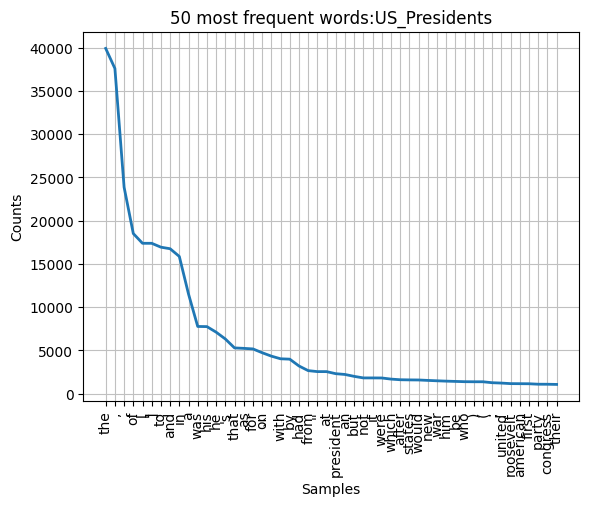

FreqDist({'the': 39924, ',': 37604, '.': 23872, 'of': 18515, '[': 17389, ']': 17388, 'to': 16940, 'and': 16759, 'in': 15869, 'a': 11522, ...})

In [21]:

Predidents=pre_sci_df['clean_text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' ')
tokens = word_tokenize(Predidents)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
plt.title("50 most frequent words:US_Presidents")
frequency_dist.plot(50)
frequency_dist

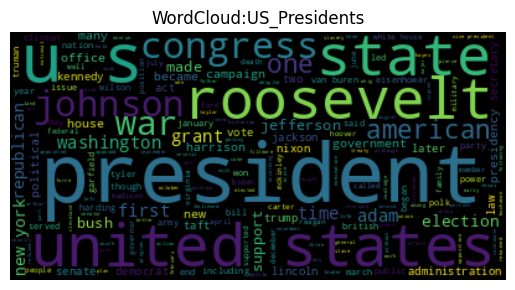

In [21]:

wordcloud = WordCloud().generate(Predidents)
plt.title("WordCloud:US_Presidents")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 50 most frequent words and word cloud for *Women_Scientists*

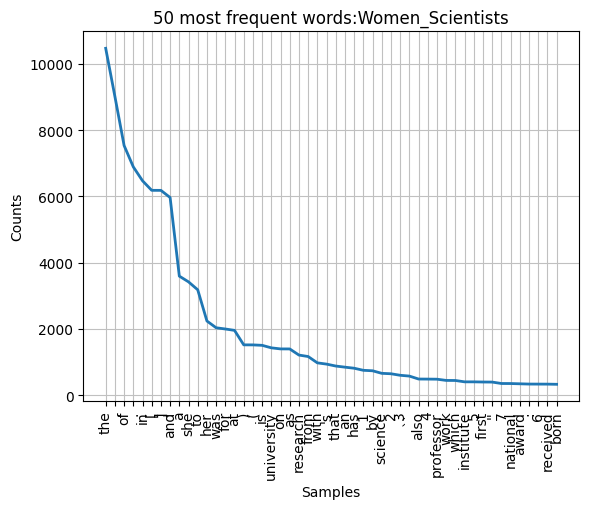

FreqDist({'the': 10471, ',': 9017, 'of': 7537, '.': 6893, 'in': 6474, '[': 6185, ']': 6184, 'and': 5968, 'a': 3596, 'she': 3423, ...})

In [22]:
Scientists=pre_sci_df['clean_text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' ')
tokens = word_tokenize(Scientists)
vocabulary = set(tokens)
plt.title("50 most frequent words:Women_Scientists")
frequency_dist = nltk.FreqDist(tokens)
frequency_dist.plot(50)
frequency_dist

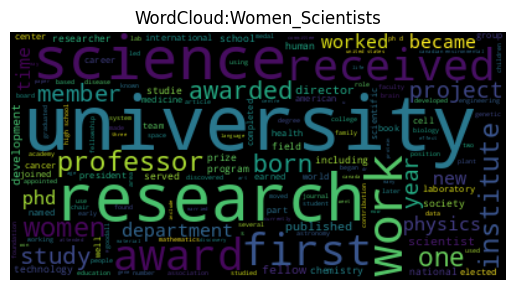

In [23]:

wordcloud = WordCloud().generate(Scientists)
plt.title("WordCloud:Women_Scientists")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Extracting the sentence of each category

In [35]:
sent_pre = pre_sci_df['clean_text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' ')
number_sent_pre = sent_tokenize(sent_pre)
num_sent_pre=len(number_sent_pre)
num_sent_pre


23997

In [48]:
sent_sci = pre_sci_df['clean_text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' ')
number_sent_sci = sent_tokenize(sent_sci)
num_sent_sci=len(number_sent_sci)
num_sent_sci

6913

In [47]:
print("number of sentence:US_Presidents:",num_sent_pre)
print("number of sentence:Women_Scientists:",num_sent_sci)

number of sentence:US_Presidents: 23997
number of sentence:Women_Scientists: 6913


# Min/max/avg number of sentences : US_Presidents

In [ ]:
len_sent_pre=[]
for i in number_sent_pre:
  len_sent_pre.append(len(i))
len_sent_pre

In [22]:

print("Min number of sentence: US_Presidents: ", min(len_sent_pre))
print("Max number of sentence: US_Presidents: ",max(len_sent_pre))
print("Avg number of sentence: US_Presidents: ",sum(len_sent_pre)/len(len_sent_pre))

Min number of sentence: US_Presidents:  3
Max number of sentence: US_Presidents:  1240
Avg number of sentence: US_Presidents:  152.88144351377255


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d34418bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d3443e130>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d34418910>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d3443e670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d3443e910>],
 'means': []}

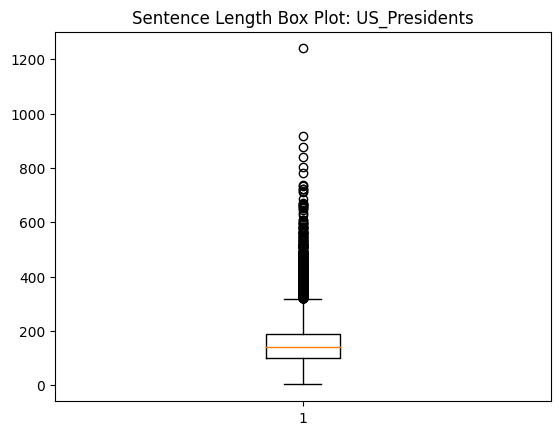

In [23]:

data_sent_pre = len_sent_pre

plt.title('Sentence Length Box Plot: US_Presidents')

plt.boxplot(data_sent_pre)

Text(0, 0.5, 'Frequency')

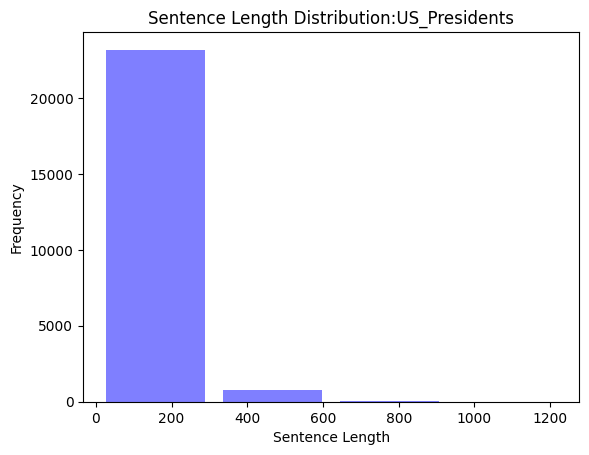

In [28]:
data_sent_pre = len_sent_pre

num_bins = 4

plt.hist(data_sent_pre, num_bins, color='blue', alpha=0.5, rwidth=0.85)
plt.title('Sentence Length Distribution:US_Presidents')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Min/max/avg number of sentences : Women_Scientists

In [ ]:
len_sent_sci=[]
for w in number_sent_sci:
  len_sent_sci.append(len(w))
len_sent_sci

In [42]:

print("Min number of sentence:Women_Scientists: ", min(len_sent_sci))
print("Max number of sentence:Women_Scientists: ", max(len_sent_sci))
print("Avg number of sentence:Women_Scientists ",sum(len_sent_sci)/len(len_sent_sci))

Min number of sentence:Women_Scientists:  1
Max number of sentence:Women_Scientists:  1065
Avg number of sentence:Women_Scientists  158.15521481267177


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0d3422d1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0d3422d700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0d3421dee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0d3422dc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0d3422dee0>],
 'means': []}

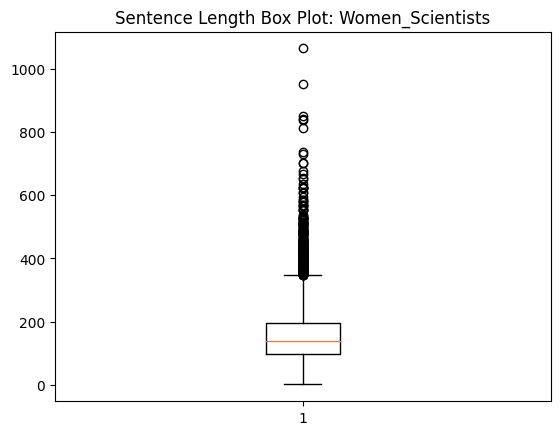

In [27]:

data_sent_sci = len_sent_sci

plt.title('Sentence Length Box Plot: Women_Scientists')

plt.boxplot(data_sent_sci)

Text(0, 0.5, 'Frequency')

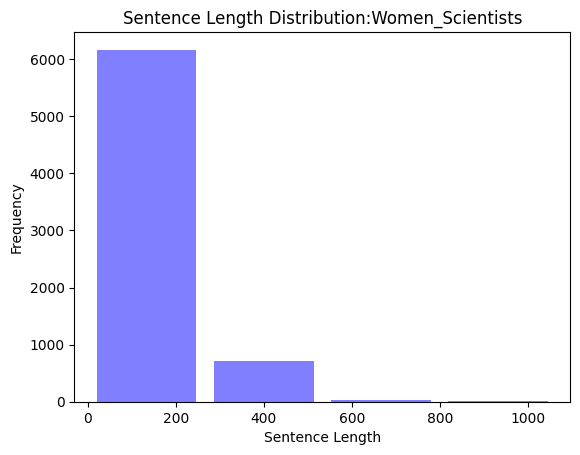

In [33]:
data_sent_sci = len_sent_sci

num_bins = 4

plt.hist(data_sent_sci, num_bins, color='blue', alpha=0.5, rwidth=0.85)
plt.title('Sentence Length Distribution:Women_Scientists')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Extracting the token of each category

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [29]:
nlp.max_length = 4787754

In [32]:
def get_tokens(cat):
    subframe = pre_sci_df[pre_sci_df['category'] == cat]
    texts = subframe['clean_text'].str.cat(sep=" ")
    doc = nlp(texts)
    words = [word.text for word in doc]
    vocab = list(set(words))
    print(str(len(vocab))+" tokens in category "+cat)
    return(" ". join(vocab))


vocabs = []
for c in Categories:
    vocab = get_tokens(c)
    vocabs.append(vocab)

39521 tokens in category US_Presidents
21490 tokens in category Women_Scientists


In [33]:
data_corpus = {'CATEGORY':Categories,'VOCABULARY':vocabs}
data_df = pd.DataFrame(data_corpus) 
data_df["VOCAB SIZE"] = data_df["VOCABULARY"].str.split().apply(len)
data_df

,CATEGORY,VOCABULARY,VOCAB SIZE
0,US_Presidents,lemann grayson force.[218]thousands foresaw ho...,39513
1,Women_Scientists,apl 1982.[1 biology[7 undermining harmful אסנת...,21483


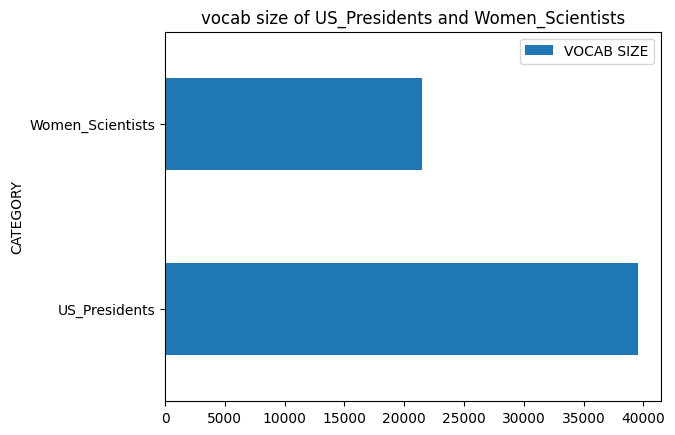

In [28]:
ax = data_df.plot.barh(x='CATEGORY', y='VOCAB SIZE',title="vocab size of US_Presidents and Women_Scientists", rot=0)

# Min/max/avg number of token occurrences per sentence:US_Presidents

In [ ]:

token_sen_pre = []
for sent in number_sent_pre:
    nltk_tokens = nltk.word_tokenize(sent)
    
    token_sen_pre.append(len(nltk_tokens))

token_sen_pre




In [45]:

print("Min number of token occurrences per sentence:US_Presidents: ", min(token_sen_pre))
print("Max number of token occurrences per sentence:US_Presidents: ", max(token_sen_pre))
print("Avg number of token occurrences per sentence:US_Presidents ",sum(token_sen_pre)/len(token_sen_pre))

Min number of token occurrences per sentence:US_Presidents:  1
Max number of token occurrences per sentence:US_Presidents:  195
Avg number of token occurrences per sentence:US_Presidents  30.09214523361782


# Min/max/avg number of token occurrences per sentence:Women_Scientists

In [ ]:

token_sen_pre = []
for sent in number_sent_sci:
    nltk_tokens = nltk.word_tokenize(sent)
    
    token_sen_pre.append(len(nltk_tokens))

token_sen_pre


In [44]:

print("Min number of token occurrences per sentence:Women_Scientists: ", min(token_sen_pre))
print("Max number of token occurrences per sentence:US_Women_Scientists: ", max(token_sen_pre))
print("Avg number of token occurrences per sentence:US_Women_Scientists ",sum(token_sen_pre)/len(token_sen_pre))

Min number of token occurrences per sentence:Women_Scientists:  1
Max number of token occurrences per sentence:US_Women_Scientists:  195
Avg number of token occurrences per sentence:US_Women_Scientists  30.09214523361782


# Bonus

# Named Entities (NER), NOUN, VERB, ADJ: US_Presidents

In [ ]:
text = pre_sci_df['text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' ')
doc = nlp(text)
ents = [(e.label_) for e in doc.ents]
print(ents)

displacy.render(doc, style='ent', jupyter=True)

In [31]:
NER_pre=Counter(ents).most_common(20)

In [32]:
spacy.explain("TIME")

'Times smaller than a day'

In [33]:
df_NER_pre = pd.DataFrame(NER_pre, columns=['NER', 'count_NER'])

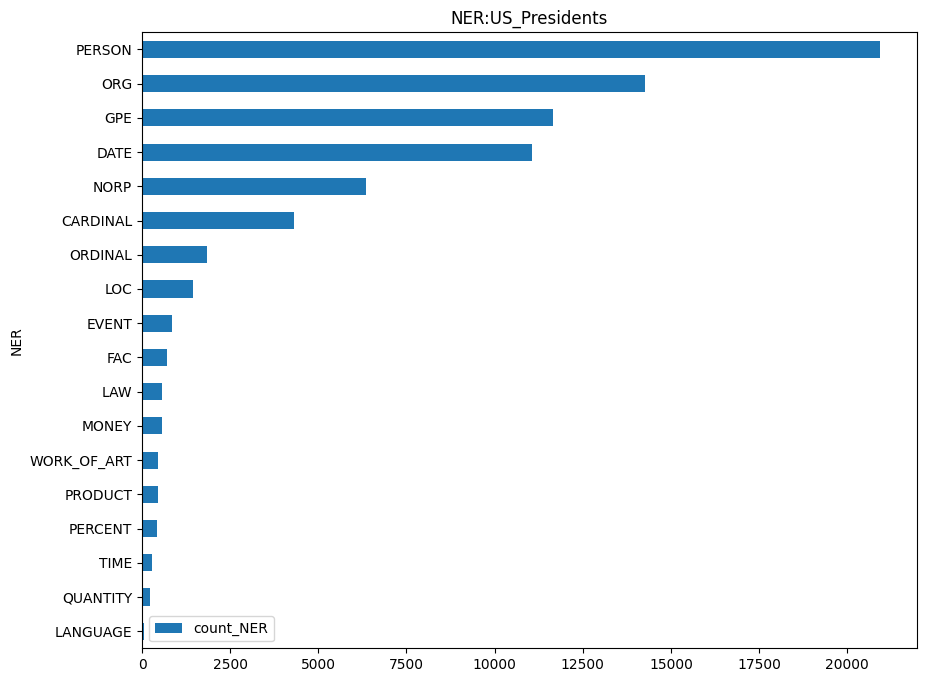

In [34]:
df_NER_pre.plot.barh(x='NER', y='count_NER', title="NER:US_Presidents", figsize=(10,8)).invert_yaxis()

In [ ]:
doc_pre = nlp(pre_sci_df['text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' '))
for token in doc_pre :
    print(token.text, token.pos_)

In [36]:

nouns = [token.text for token in doc_pre if token.pos_ == 'NOUN']
verbs = [token.text for token in doc_pre if token.pos_ == 'VERB']
adjs=[token.text for token in doc_pre if token.pos_ == 'ADJ']
nouns_tally = Counter(nouns)
verbs_tally = Counter(verbs)
adjs_tally=Counter(adjs)

df_nouns_pre = pd.DataFrame(nouns_tally.most_common(), columns=['noun', 'count_noun'])
df_verbs_pre = pd.DataFrame(verbs_tally.most_common(), columns=['verb', 'count_verb'])
df_adjs_pre = pd.DataFrame(nouns_tally.most_common(), columns=['adjs', 'count_adj'])

In [37]:
df_pre = pd.concat([df_nouns_pre, df_verbs_pre,df_adjs_pre,df_NER_pre], axis = 1)
df_pre.head()

,noun,count_noun,verb,count_verb,adjs,count_adj,NER,count_NER
0,president,1382,had,835.0,president,1382,PERSON,20932.0
1,election,928,became,668.0,election,928,ORG,14255.0
2,time,721,made,629.0,time,721,GPE,11644.0
3,war,691,won,488.0,war,691,DATE,11058.0
4,state,677,including,472.0,state,677,NORP,6355.0


# Named Entities (NER), NOUN, VERB, ADJ: Women_Scientists

In [ ]:
text = pre_sci_df['text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' ')
doc = nlp(text)
ents = [(e.label_) for e in doc.ents]
print(ents)

displacy.render(doc, style='ent', jupyter=True)

In [39]:
NER_sci=Counter(ents).most_common(20)

In [40]:
df_NER_sci = pd.DataFrame(NER_sci, columns=['NER', 'count_NER'])

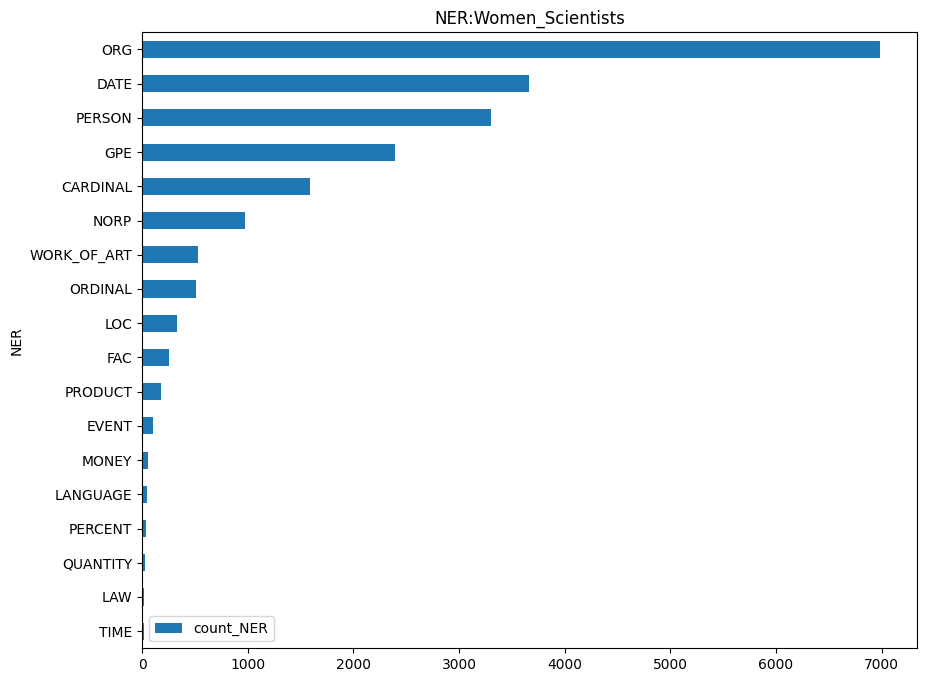

In [41]:
df_NER_sci.plot.barh(x='NER', y='count_NER', title="NER:Women_Scientists", figsize=(10,8)).invert_yaxis()

In [ ]:
doc_sci = nlp(pre_sci_df['text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' '))
for token in doc_sci :
    print(token.text, token.pos_)

In [43]:

nouns = [token.text for token in doc_sci if token.pos_ == 'NOUN']
verbs = [token.text for token in doc_sci if token.pos_ == 'VERB']
adjs=[token.text for token in doc_sci if token.pos_ == 'ADJ']
nouns_tally = Counter(nouns)
verbs_tally = Counter(verbs)
adjs_tally=Counter(adjs)

df_nouns_sci = pd.DataFrame(nouns_tally.most_common(), columns=['noun', 'count_noun'])
df_verbs_sci = pd.DataFrame(verbs_tally.most_common(), columns=['verb', 'count_verb'])
df_adjs_sci = pd.DataFrame(nouns_tally.most_common(), columns=['adjs', 'count_adj'])

In [44]:
df_sci = pd.concat([df_nouns_sci, df_verbs_sci,df_adjs_sci,df_NER_sci], axis = 1)
df_sci.head()

,noun,count_noun,verb,count_verb,adjs,count_adj,NER,count_NER
0,research,745,born,335.0,research,745,ORG,6985.0
1,work,401,received,335.0,work,401,DATE,3658.0
2,professor,277,awarded,247.0,professor,277,PERSON,3306.0
3,member,228,worked,196.0,member,228,GPE,2391.0
4,degree,223,became,194.0,degree,223,CARDINAL,1594.0
